## LSTM

In [72]:
import pandas as pd

data_global = pd.read_csv('dataset//global-temp_monthly.csv')


In [73]:
data_gcag = data_global[data_global.Source=='gcag']

In [82]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

Y = np.zeros(shape=(len(data_gcag), 1), dtype=np.float32)

for i in range(len(data_gcag)):
    Y[i, 0] = data_gcag.iloc[i]['Mean']

mmscaler = MinMaxScaler((-1.0, 1.0))
Y = mmscaler.fit_transform(Y)

In [84]:
nb_samples = 1600
nb_test_samples = 200
sequence_length = 20

X_ts = np.zeros(shape=(nb_samples - sequence_length, sequence_length, 1), dtype=np.float32)
Y_ts = np.zeros(shape=(nb_samples - sequence_length, 1), dtype=np.float32)

for i in range(0, nb_samples - sequence_length):
    X_ts[i] = Y[i:i + sequence_length]
    Y_ts[i] = Y[i + sequence_length]

X_ts_train = X_ts[0:nb_samples - nb_test_samples, :]
Y_ts_train = Y_ts[0:nb_samples - nb_test_samples]

X_ts_test = X_ts[nb_samples - nb_test_samples:, :]
Y_ts_test = Y_ts[nb_samples - nb_test_samples:]

In [85]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Flatten, InputLayer

model = Sequential()

#Quando uma LSTM é seguida por outra camada LSTM, a primeira deve ter o parâmetro return_sequences=True. 
#model.add(LSTM(8, stateful=True, return_sequences=True, batch_input_shape=(20, sequence_length, 1)))

model.add(InputLayer(batch_input_shape=(20, sequence_length, 1)))
model.add(LSTM(8, stateful=True))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('linear'))

In [86]:
from keras.optimizers import Adam
import tensorflow as tf

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000, 
    decay_rate=1-1e-4,
    staircase=True    
)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mse'])

In [87]:
history = model.fit(X_ts_train, Y_ts_train,
          batch_size=20,
          epochs=100,
          shuffle=False,
          validation_data=(X_ts_test, Y_ts_test))


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.01

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


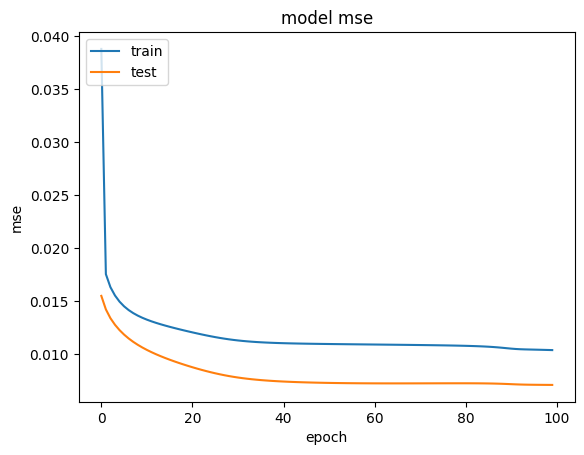

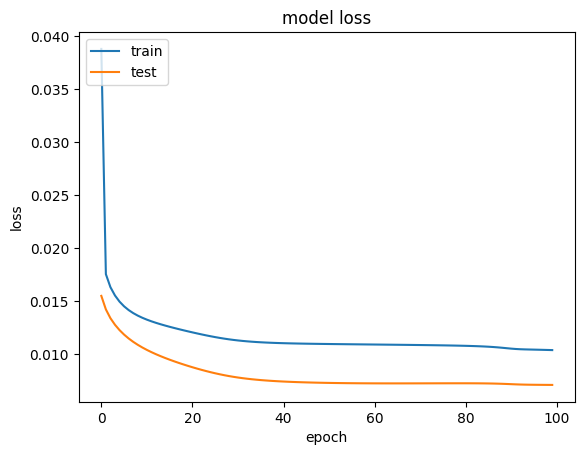

In [88]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


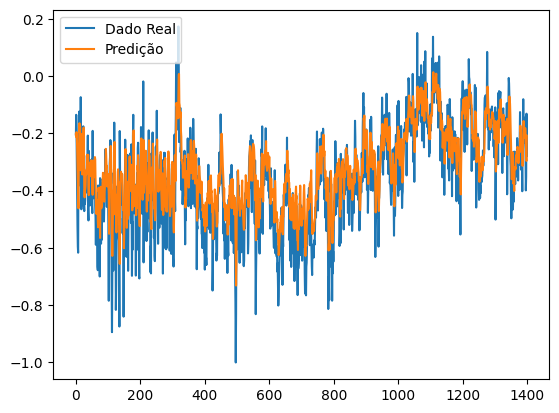

In [89]:
# summarize history for loss
plt.plot(Y_ts_train)
plt.plot(model.predict(X_ts_train, batch_size=20))
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
plt.legend(['Dado Real', 'Predição'], loc='upper left')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


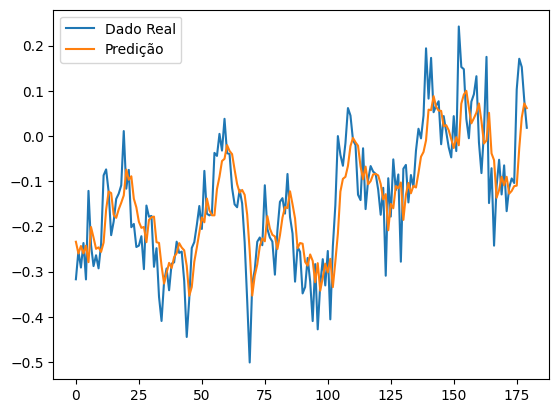

In [90]:
# summarize history for loss
plt.plot(Y_ts_test)
plt.plot(model.predict(X_ts_test, batch_size=20))
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
plt.legend(['Dado Real', 'Predição'], loc='upper left')
plt.show()

## Autoencoder

### Standard Autoencoder

In [30]:
import numpy as np
from PIL import Image

from keras.datasets import fashion_mnist

(X_train, _), (_, _) = fashion_mnist.load_data()

nb_samples = 1000
nb_epochs = 100 # 400
batch_size = 200
code_length = 256

X_train = X_train.astype(np.float32)[0:nb_samples] / 255.0

width = X_train.shape[1]
height = X_train.shape[2]

In [31]:
import tensorflow as tf
print("Eager Execution:", tf.executing_eagerly())

Eager Execution: True


In [260]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose,Lambda, Reshape
from tensorflow.keras.models import Model
from keras import Input

# Define the model using the functional API
input_images = Input(shape=(width, height, 1))  # Input layer

# Resize the input images
#r_input_images = tf.image.resize(input_images, (32, 32))
r_input_images = Lambda(lambda x: tf.image.resize(x, (32, 32)))(input_images)

# Encoder
conv_0 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(r_input_images)
conv_1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv_0)
conv_2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv_1)

# Code layer (Flatten + Dense for the latent space)
code_input = Flatten()(conv_2)
code_layer = Dense(units=code_length, activation='sigmoid')(code_input)


# Decoder
decoder_input = Reshape((16, 16, 1))(code_layer) 

convt_0 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(decoder_input)
convt_1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(convt_0)
convt_2 = Conv2DTranspose(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(convt_1)
convt_3 = Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(convt_2)

output_images = Lambda(lambda x: tf.image.resize(x, (28, 28)))(convt_3)

def custom_l2_loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred)**2)
    
# Define the model
model = Model(inputs=input_images, outputs=output_images)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_l2_loss)

In [266]:
from tensorflow.keras import layers, models

model.fit(X_train, X_train,
                epochs=nb_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_train, X_train))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0464 - val_loss: 0.0411
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0400 - val_loss: 0.0369
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 0.0356 - val_loss: 0.0319
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0317 - val_loss: 0.0295
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.0288 - val_loss: 0.0266
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 0.0266 - val_loss: 0.0244
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0242 - val_loss: 0.0227
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0225 - val_loss: 0.0211
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0211 - val_loss: 0.0198
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0196 - val_loss: 0.0181
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0183 - val_loss: 0.0182
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0179 - val_loss: 0.0167
Ep

In [267]:
reconstructed_images = model.predict(X_train)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step


In [268]:
import numpy as np

Ys = np.squeeze(reconstructed_images)

In [269]:
custom_l2_loss(X_train[0], Ys[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.004902863>

In [270]:
import IPython
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

    im = Image.fromarray(Ys[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

In [234]:
autoencoder = models.Model(input_images, output_images)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train, X_train,
                epochs=nb_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X_train, X_train))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.1356 - val_loss: 0.1334
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1334 - val_loss: 0.1321
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.1308 - val_loss: 0.1293
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1276 - val_loss: 0.1229
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1198 - val_loss: 0.1041
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0988 - val_loss: 0.0891
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.0860 - val_loss: 0.0762
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.0744 - val_loss: 0.0671
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0659 - val_loss: 0.0627
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.0607 - val_loss: 0.0597
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0588 - val_loss: 0.0568
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0564 - val_loss: 0.0541
Epoch 1

In [235]:
reconstructed_images = autoencoder.predict(X_train)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


In [236]:
import numpy as np

Ys = np.squeeze(reconstructed_images)

In [237]:
custom_l2_loss(X_train[0], Ys[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9.680649e-05>

In [238]:
import IPython
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

    im = Image.fromarray(Ys[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

### denoising autoencoder

In [239]:
input_noisy_images = np.copy(X_train)
test_noisy_images = np.copy(X_train)
for i in range(0, len(input_noisy_images)):
    #input_noisy_images[i] = np.clip(input_noisy_images[i] + np.random.normal(0, 0.8, size=(width, height)), 0.0, 1.0)
    input_noisy_images[i] = np.clip(input_noisy_images[i] + np.random.normal(-0.3, 0.3, size=(width, height)), 0.0, 1.0)
    test_noisy_images[i] = np.clip(input_noisy_images[i] + np.random.normal(0.0, 0.2, size=(width, height)), 0.0, 1.0)

In [240]:
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)
    
    im = Image.fromarray(input_noisy_images[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

In [271]:

# Define the autoencoder model using tf.keras
model = models.Sequential()

model.add(Input(shape=(width, height, 1)))
# Encoder
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))

# Code layer (flatten and dense layer)
model.add(layers.Flatten())
model.add(layers.Dense(width * height, activation='sigmoid'))  # Latent space

# Decoder
model.add(layers.Reshape((width, height, 1)))
model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))  # Output layer


In [277]:

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_l2_loss)

# Train the model
model.fit(input_noisy_images, X_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0448
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.0277
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.0209
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - loss: 0.0193
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.0177
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0163
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - loss: 0.0153
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - loss: 0.0142
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - loss: 0.0135
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - loss: 0.0132
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - loss: 0.0124
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 0.0120
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 0.0116
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.0113
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 0.0108
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━


KeyboardInterrupt



In [273]:
reconstructed_images = model.predict(test_noisy_images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step


In [274]:
import numpy as np

Ys = np.squeeze(reconstructed_images)
custom_l2_loss(X_train[0], Ys[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0505578>

In [275]:
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

    im = Image.fromarray(test_noisy_images[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)
    
    im = Image.fromarray(Ys[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

### Sparse autoencoder

In [246]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Input, Reshape
from tensorflow.keras import Model
import numpy as np

# Input layer
input_images = Input(shape=(width, height, 1))

# Resize input images
#r_input_images = tf.image.resize(input_images, (32, 32))
r_input_images = Lambda(lambda x: tf.image.resize(x, (32, 32)))(input_images)

# Encoder
conv_0 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(r_input_images)
conv_1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv_0)
conv_2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv_1)

# Code layer (latent space)
code_input = Flatten()(conv_2)
code_layer = Dense(units=code_length, activation='sigmoid', activity_regularizer=tf.keras.regularizers.l1(0.001))(code_input)
# Sparsity constraint for code layer
#sparsity_constraint = tf.reduce_sum(0.001 * tf.norm(code_layer, ord=1, axis=1))

# Decoder
decoder_input = Reshape((16, 16, 1))(code_layer)

convt_0 = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(decoder_input)
convt_1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(convt_0)
convt_2 = Conv2DTranspose(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(convt_1)
convt_3 = Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(convt_2)

output_images = Lambda(lambda x: tf.image.resize(x, (28, 28)))(convt_3)

# Model
autoencoder = Model(inputs=input_images, outputs=output_images)

# Compile the model
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_l2_loss)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

#autoencoder.summary()


In [247]:
from tensorflow.keras import layers, models

autoencoder.fit(X_train, X_train,
                epochs=nb_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_train, X_train))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 17.5408 - val_loss: 0.2006
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1774 - val_loss: 0.1418
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.1387 - val_loss: 0.1414
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1392 - val_loss: 0.1336
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1352 - val_loss: 0.1359
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 0.1358 - val_loss: 0.1332
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.1313 - val_loss: 0.1338
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1328 - val_loss: 0.1325
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1311 - val_loss: 0.1325
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1334 - val_loss: 0.1319
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.1326 - val_loss: 0.1315
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.1313 - val_loss: 0.1310
Ep

In [278]:
reconstructed_images = autoencoder.predict(X_train)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


In [279]:
import numpy as np

Ys = np.squeeze(reconstructed_images)
custom_l2_loss(X_train[0], Ys[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.13853364>

In [280]:
import IPython
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

    im = Image.fromarray(Ys[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

### variational autoencoder

In [251]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling((z_mean, z_log_var))
            reconstruction = self.decoder(z)            
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(Reshape((width, height,1))(data), reconstruction)
            )
            reconstruction_loss *= width * height
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean, z_log_var = self.encoder(data)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [252]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Input, Lambda
from tensorflow.keras.models import Model
import numpy as np

# Model parameters
latent_dim = int((width * height) * 0.1)

# Encoder
input_images = Input(shape=(width, height, 1))

conv_0 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(input_images)
conv_1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(conv_0)
conv_2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv_1)

# Flatten and latent space
code_input = Flatten()(conv_2)
code_mean = Dense(units=latent_dim,name="z_mean")(code_input)
code_log_variance = Dense(units=latent_dim,name="z_log_var")(code_input)
encoder = tf.keras.Model(input_images, [code_mean, code_log_variance], name="encoder")


latent_inputs = Input(shape=(latent_dim,))
sampled_code = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Decoder
decoder_input = Reshape((7, 7, 64))(sampled_code)
convt_0 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(decoder_input)
convt_1 = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(convt_0)
convt_output = Conv2DTranspose(filters=1, kernel_size=(3, 3), activation="sigmoid", padding='same')(convt_1)
decoder = tf.keras.Model(latent_inputs, convt_output, name="decoder")


vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

vae.fit(X_train,X_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - kl_loss: 0.3474 - loss: 524.2626 - reconstruction_loss: 523.9152
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - kl_loss: 2.2529 - loss: 457.1425 - reconstruction_loss: 454.8896
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - kl_loss: 1.5644 - loss: 399.5334 - reconstruction_loss: 397.9690
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - kl_loss: 1.8908 - loss: 383.1284 - reconstruction_loss: 381.2376
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - kl_loss: 2.0837 - loss: 371.6496 - reconstruction_loss: 369.5659
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - kl_loss: 1.9697 - loss: 354.8861 - reconstruction_loss: 352.9164
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - kl_loss: 2.3316 - loss: 336.5841 - reconstruction_loss: 334.2525
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - kl_loss: 2.9290 - loss: 328.1589 - reconstruction_loss: 325.2299
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - kl_

In [253]:
reconstructed_images = vae.predict(X_train)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [254]:
import numpy as np

Ys = np.squeeze(reconstructed_images)

In [255]:
import IPython
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

    im = Image.fromarray(Ys[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

### GAN

In [13]:
import numpy as np

from keras.datasets import fashion_mnist

nb_samples = 1 # 5000

(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32)[0:nb_samples] / 255.0
X_train = (2.0 * X_train) - 1.0

width = X_train.shape[1]
height = X_train.shape[2] 

In [55]:
print(tf.__version__)

2.17.0


In [5]:

# Training parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BUFFER_SIZE = 60000
BATCH_SIZE = 128
code_length = 100
width, height = 64, 64  # Define your width and height

#### DCGAN

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Input, Lambda, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Model

def make_generator_model(latent_dim):
    model = tf.keras.Sequential()

    #model.add(Input(shape=(1, 1, code_length)))
    model.add(Dense(7 * 7 * 1024, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 1024)))

    model.add(Conv2DTranspose(filters=1024, kernel_size=(4, 4), padding='valid'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
                  
    model.add(Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
                  
    model.add(Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
                  
    model.add(Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
                  
    model.add(Conv2DTranspose(filters=1, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='tanh'))

    return model

make_generator_model().summary()

TypeError: make_generator_model() missing 1 required positional argument: 'latent_dim'

In [36]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Define the model using the functional API
    #model.add(Input(shape=(width, height, 1)))  # Input layer
    model.add(Input(shape=(64,64, 1)))  # Input layer

    # Define layers in the discriminator
    model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(filters=1024, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(filters=1, kernel_size=(4, 4), padding='valid'))
    model.add(LeakyReLU())

    return model

make_discriminator_model().summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)                   │ (None, 32, 32, 128)         │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_84 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_85 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 8, 8, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_86 (LeakyReLU)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 4, 4, 1024)          │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 4, 4, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_87 (LeakyReLU)           │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 1, 1, 1)             │          16,385 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_88 (LeakyReLU)           │ (None, 1, 1, 1)             │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,037,569 (42.10 MB)

 Trainable params: 11,033,985 (42.09 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [41]:
def define_discriminator():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, 3, strides=2, padding='same',
                          input_shape=(28, 28, 1)),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.5),
            
            layers.Conv2D(64, 3, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.5),
            
            layers.Conv2D(128, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.5),
            
            layers.Conv2D(256, 3, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.5),
            
            layers.GlobalMaxPooling2D(),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    
    return model

In [42]:
def define_generator(latent_size):
    model = tf.keras.Sequential(
        [
            layers.Dense(7 * 7 * 128, input_dim=latent_size),
            layers.LeakyReLU(alpha=0.2),
            layers.Reshape((7, 7, 128)),
            
            layers.Conv2DTranspose(128, 4, strides=2, padding='same',
                                   kernel_initializer='glorot_normal'),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            
            layers.Conv2DTranspose(128, 4, strides=2, padding='same',
                                   kernel_initializer='glorot_normal'),
            layers.LeakyReLU(alpha=0.2),
            layers.BatchNormalization(),
            
            layers.Conv2D(1, 7, padding='same',
                          activation='tanh',
                          kernel_initializer='glorot_normal')
        ]
    )
    
    return model

In [49]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        print(generated_images.shape)
        print(real_images.shape)
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [50]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [51]:
np.random.seed(1337)
num_classes = 10

epochs = 30
latent_dim = 128

adam_lr = 0.0002
adam_beta_1 = 0.5


#discriminator = make_discriminator_model()
#generator = make_generator_model(latent_dim)

discriminator = define_discriminator()
generator = define_generator(latent_dim)


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
        d_optimizer=tf.keras.optimizers.Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        g_optimizer=tf.keras.optimizers.Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    )

In [54]:
tf.config.run_functions_eagerly(True)

gan.fit(
    np.reshape(X_train, (-1, 28, 28, 1)),
    epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/30


D:\Backup\OneDrive - puc-rio.br\Jupyter\venvs\mlclass\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(1, 28, 28, 1)
(1, 28, 28, 1)


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [3,3,1,32] vs. [0] [Op:Sub]

0 / 50
0


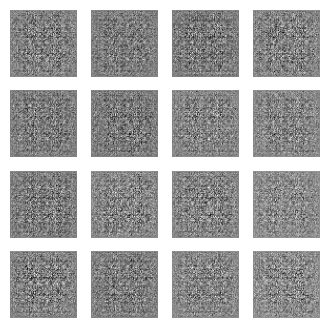

Time for epoch 1 is complete
1 / 50
0


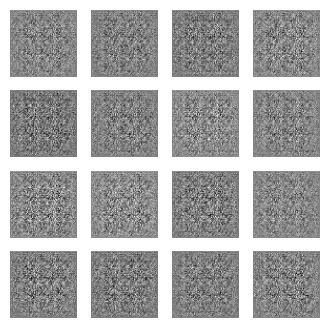

Time for epoch 2 is complete
2 / 50
0


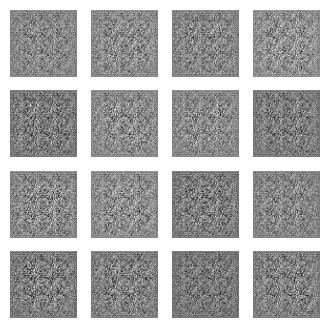

Time for epoch 3 is complete
3 / 50
0


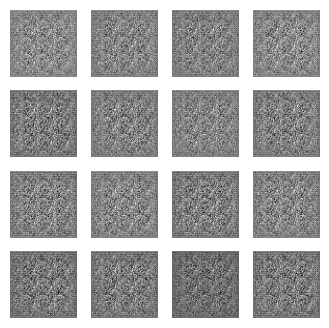

Time for epoch 4 is complete
4 / 50
0


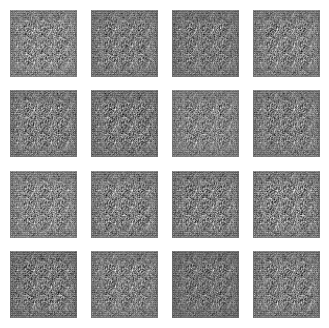

Time for epoch 5 is complete
5 / 50
0


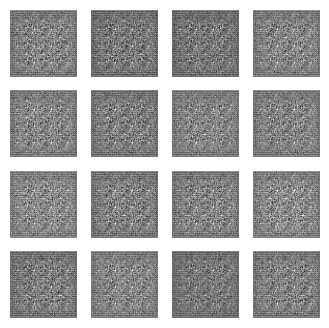

Time for epoch 6 is complete
6 / 50
0


KeyboardInterrupt: 

In [22]:

# Instantiate generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Seed for consistent visualization
#seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed = np.random.uniform(-1.0, 1.0, size=(num_examples_to_generate, code_length)).astype(np.float32)
seed = tf.reshape(seed, (-1, 1, 1, code_length))

# Training step function
@tf.function
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise = np.random.uniform(-1.0, 1.0, size=(BATCH_SIZE, code_length)).astype(np.float32)
    noise = tf.reshape(noise, (-1, 1, 1, code_length))
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        #print(noise.shape)
        generated_images = generator(noise, training=True)
        
        images = tf.expand_dims(images, axis=-1)  # Add channel dimension
        images = tf.expand_dims(images, axis=0)   # Add batch dimension
        ri = tf.image.resize(images, (64, 64))

        #print(ri.shape)
        real_output = discriminator(ri, training=True)

        #print(generated_images.shape)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    
    for epoch in range(epochs):
        print("epoch:",epoch,"/",epochs)
        i = 0
        for image_batch in dataset:
            print("b",i,"/", len(dataset))
            i += 1
            train_step(image_batch)

        # Produce images for the GIF as we go
        #display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Time for epoch {epoch + 1} is complete')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


import matplotlib.pyplot as plt
# Image generation and saving function
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Start training
train(X_train, EPOCHS)


KeyboardInterrupt



In [23]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Load the Fashion MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize the images to the range [-1, 1]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Rescale to [-1, 1]

# Create a TensorFlow Dataset for the training data
BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



def build_generator():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model




def build_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model



def build_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
    discriminator.trainable = False  # Freeze the discriminator while training the generator

    model = tf.keras.Sequential([generator, discriminator])
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
    return model



# Define the function to train the DCGAN
def train_dcgan(generator, discriminator, gan, dataset, epochs=50):
    # Labels for real and fake images
    real_labels = np.ones((BATCH_SIZE, 1))
    fake_labels = np.zeros((BATCH_SIZE, 1))

    for epoch in range(epochs):
        for batch in dataset:
            noise = tf.random.normal([BATCH_SIZE, 100])

            # Generate fake images
            generated_images = generator(noise, training=False)

            # Train the discriminator
            with tf.GradientTape() as disc_tape:
                real_output = discriminator(batch, training=True)
                fake_output = discriminator(generated_images, training=True)
                disc_loss_real = tf.keras.losses.BinaryCrossentropy(from_logits=True)(real_labels, real_output)
                disc_loss_fake = tf.keras.losses.BinaryCrossentropy(from_logits=True)(fake_labels, fake_output)
                disc_loss = disc_loss_real + disc_loss_fake
            grads_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator.optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))

            # Train the generator
            with tf.GradientTape() as gen_tape:
                fake_output = discriminator(generated_images, training=False)
                gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(real_labels, fake_output)
            grads_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator.optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))

        print(f"Epoch {epoch+1}/{epochs} | Disc Loss: {disc_loss:.4f} | Gen Loss: {gen_loss:.4f}")
        # Optionally, visualize the generated images
        if (epoch + 1) % 10 == 0:
            plot_generated_images(generator, epoch + 1)

# Function to plot generated images
def plot_generated_images(generator, epoch, examples=16, dim=(4, 4), figsize=(10, 10)):
    noise = tf.random.normal([examples, 100])
    generated_images = generator(noise, training=False)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.show()



# Initialize the models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Train the DCGAN
train_dcgan(generator, discriminator, gan, train_dataset, epochs=50)


D:\Backup\OneDrive - puc-rio.br\Jupyter\venvs\mlclass\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\Backup\OneDrive - puc-rio.br\Jupyter\venvs\mlclass\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: not enough values to unpack (expected 2, got 0)

In [42]:
import tensorflow as tf

# Set up constants
code_length = 100
width, height = 64, 64  # Define your width and height

# Define input layers
input_x = tf.keras.layers.Input(shape=(width, height, 1), name='input_x')
input_z = tf.keras.layers.Input(shape=(code_length,), name='input_z')

# Reshape input_z for generator compatibility
#input_z_reshaped = tf.reshape(input_z, (-1, 1, 1, code_length))
input_z_reshaped = Reshape((1, 1, code_length))(input_z)

# Instantiate generator and discriminators
#gen = generator(z=input_z_reshaped, is_training=True)
g = Generator()
gen = g.call(z=input_z_reshaped, is_training=True)
#r_input_x = tf.image.resize(input_x, (64, 64))
r_input_x = Lambda(lambda x: tf.image.resize(x, (64, 64)))(input_x)

#discr_1_l = discriminator(x=r_input_x, is_training=True, reuse_variables=False)
d1 = Discriminator()
discr_1_l = d1.call(x=r_input_x, is_training=True)

#discr_2_l = discriminator(x=gen, is_training=True, reuse_variables=True)
#d2 = Discriminator()
discr_2_l = d1.call(x=gen, is_training=True)

# Define losses
loss_d_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_1_l), logits=discr_1_l))
loss_d_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(discr_2_l), logits=discr_2_l))
loss_d = loss_d_1 + loss_d_2

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_2_l), logits=discr_2_l))

# Define optimizers and training steps
variables_g = [var for var in gen.trainable_variables if 'generator' in var.name]
variables_d = [var for var in discr_1_l.trainable_variables if 'discriminator' in var.name]

# Optimizers
optimizer_d = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
optimizer_g = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

@tf.function
def train_step(input_x, input_z):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g:
        gen_output = generator(input_z, is_training=True)
        
        #r_input_x_resized = tf.image.resize(input_x, (64, 64))
        r_input_x_resized = Lambda(lambda x: tf.image.resize(x, (64, 64)))(input_x)

        
        discr_real = discriminator(r_input_x_resized, is_training=True, reuse_variables=False)
        discr_fake = discriminator(gen_output, is_training=True, reuse_variables=True)
        
        # Calculate losses
        loss_d_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_real), logits=discr_real))
        loss_d_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(discr_fake), logits=discr_fake))
        loss_d = loss_d_1 + loss_d_2

        loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_fake), logits=discr_fake))
    
    # Apply gradients
    gradients_d = tape_d.gradient(loss_d, variables_d)
    gradients_g = tape_g.gradient(loss_g, variables_g)

    optimizer_d.apply_gradients(zip(gradients_d, variables_d))
    optimizer_g.apply_gradients(zip(gradients_g, variables_g))

    return loss_d, loss_g

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

code_length = 100

graph = tf.Graph()

with graph.as_default():
    input_x = tf.placeholder(tf.float32, shape=(None, width, height, 1))
    input_z = tf.placeholder(tf.float32, shape=(None, code_length))
    is_training = tf.placeholder(tf.bool)
    
    gen = generator(z=tf.reshape(input_z, (-1, 1, 1, code_length)), is_training=is_training)
    
    r_input_x = tf.image.resize_images(images=input_x, size=(64, 64))
        
    discr_1_l = discriminator(x=r_input_x, is_training=is_training, reuse_variables=False)
    discr_2_l = discriminator(x=gen, is_training=is_training, reuse_variables=True)
    
    loss_d_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_1_l), logits=discr_1_l))
    loss_d_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(discr_2_l), logits=discr_2_l))
    loss_d = loss_d_1 + loss_d_2
    
    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_2_l), logits=discr_2_l))
    
    variables_g = [variable for variable in tf.trainable_variables() if variable.name.startswith('generator')]
    variables_d = [variable for variable in tf.trainable_variables() if variable.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        training_step_d = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(loss=loss_d, var_list=variables_d)
        training_step_g = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(loss=loss_g, var_list=variables_g) 

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

nb_epochs = 200
batch_size = 128
nb_iterations = int(nb_samples / batch_size)

session = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()

samples_range = np.arange(nb_samples)

for e in range(nb_epochs * 5):
    d_losses = []
    g_losses = []
    
    for i in range(nb_iterations):
        print(i,"/",nb_iterations)
        Xi = np.random.choice(samples_range, size=batch_size)
        X = np.expand_dims(X_train[Xi], axis=3)
        Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)
        
        _, d_loss = session.run([training_step_d, loss_d], 
                                feed_dict={
                                    input_x: X,
                                    input_z: Z,
                                    is_training: True
                                })
        d_losses.append(d_loss)
        
        Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)
        
        _, g_loss = session.run([training_step_g, loss_g], 
                                feed_dict={
                                    input_x: X,
                                    input_z: Z,
                                    is_training: True
                                })
        
        g_losses.append(g_loss)
        
    print('Epoch {}) Avg. discriminator loss: {} - Avg. generator loss: {}'.format(e + 1, np.mean(d_losses), np.mean(g_losses)))


0 / 39
1 / 39
2 / 39
3 / 39
4 / 39
5 / 39
6 / 39
7 / 39
8 / 39
9 / 39
10 / 39
11 / 39
12 / 39
13 / 39
14 / 39
15 / 39
16 / 39
17 / 39


KeyboardInterrupt: 

In [23]:
Z = np.random.uniform(-1.0, 1.0, size=(50, code_length)).astype(np.float32)

Ys = session.run([gen], 
                 feed_dict={
                     input_z: Z,
                     is_training: False
                })

Ys = np.squeeze((Ys[0] + 1.0) * 0.5 * 255.0).astype(np.uint8)


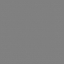

-


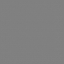

-


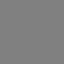

-


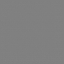

-


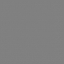

-


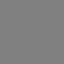

-


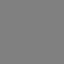

-


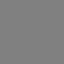

-


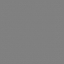

-


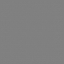

-


In [24]:
from PIL import Image

for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)
    
    im = Image.fromarray(Ys[i])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)
    print("-")

#### WGAN

In [25]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D,Conv2DTranspose, BatchNormalization

def critic(x, is_training=True, reuse_variables=True):
    with tf.variable_scope('critic', reuse=reuse_variables):
        conv_0 = Conv2D(filters=128,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(x)

        conv_1 = Conv2D(filters=256,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(conv_0))
        
        b_conv_1 = BatchNormalization()(conv_1, training=is_training)
        
        conv_2 = Conv2D(filters=512,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(b_conv_1))
        
        b_conv_2 = BatchNormalization()(conv_2, training=is_training)
        
        conv_3 = Conv2D(filters=1024,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(b_conv_2))
        
        b_conv_3 = BatchNormalization()(conv_3, training=is_training)
        
        conv_4 = Conv2D(filters=1,
                                  kernel_size=(4, 4),
                                  padding='valid')(tf.nn.leaky_relu(b_conv_3))
        
        return conv_4

In [26]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

graph = tf.Graph()

with graph.as_default():
    input_x = tf.placeholder(tf.float32, shape=(None, width, height, 1))
    input_z = tf.placeholder(tf.float32, shape=(None, code_length))
    is_training = tf.placeholder(tf.bool)
    
    gen = generator(z=tf.reshape(input_z, (-1, 1, 1, code_length)), is_training=is_training)
    
    r_input_x = tf.image.resize_images(images=input_x, size=(64, 64))
        
    crit_1_l = critic(x=r_input_x, is_training=is_training, reuse_variables=False)
    crit_2_l = critic(x=gen, is_training=is_training, reuse_variables=True)
    
    loss_c = tf.reduce_mean(crit_2_l - crit_1_l)
    loss_g = tf.reduce_mean(-crit_2_l)
    
    variables_g = [variable for variable in tf.trainable_variables() if variable.name.startswith('generator')]
    variables_c = [variable for variable in tf.trainable_variables() if variable.name.startswith('critic')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer_c = tf.train.AdamOptimizer(0.00005, beta1=0.5, beta2=0.9).minimize(loss=loss_c, var_list=variables_c)
        
        with tf.control_dependencies([optimizer_c]):
            training_step_c = tf.tuple(tensors=[tf.assign(variable, tf.clip_by_value(variable, -0.01, 0.01)) 
                                                for variable in variables_c])
        
        training_step_g = tf.train.AdamOptimizer(0.00005, beta1=0.5, beta2=0.9).minimize(loss=loss_g, var_list=variables_g)


In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

nb_epochs = 200
nb_critic = 5
batch_size = 64
nb_iterations = int(nb_samples / batch_size)

session = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()

samples_range = np.arange(nb_samples)

for e in range(nb_epochs):
    c_losses = []
    g_losses = []
    
    for i in range(nb_iterations):
        for j in range(nb_critic):
            print(i,"/",nb_iterations, "-",j,"/", nb_critic)
            Xi = np.random.choice(samples_range, size=batch_size)
            X = np.expand_dims(X_train[Xi], axis=3)
            Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)
            
            _, c_loss = session.run([training_step_c, loss_c], 
                                    feed_dict={
                                        input_x: X,
                                        input_z: Z,
                                        is_training: True
                                    })
            c_losses.append(c_loss)
        
        Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)
        
        _, g_loss = session.run([training_step_g, loss_g], 
                                feed_dict={
                                    input_x: np.zeros(shape=(batch_size, width, height, 1)),
                                    input_z: Z,
                                    is_training: True
                                })
        
        g_losses.append(g_loss)
        
    print('Epoch {}) Avg. critic loss: {} - Avg. generator loss: {}'.format(e + 1, np.mean(c_losses), np.mean(g_losses)))


0 / 78 - 0 / 5
0 / 78 - 1 / 5
0 / 78 - 2 / 5
0 / 78 - 3 / 5
0 / 78 - 4 / 5
1 / 78 - 0 / 5
1 / 78 - 1 / 5
1 / 78 - 2 / 5
1 / 78 - 3 / 5
1 / 78 - 4 / 5
2 / 78 - 0 / 5
2 / 78 - 1 / 5
2 / 78 - 2 / 5
2 / 78 - 3 / 5
2 / 78 - 4 / 5
3 / 78 - 0 / 5
3 / 78 - 1 / 5
3 / 78 - 2 / 5
3 / 78 - 3 / 5
3 / 78 - 4 / 5
4 / 78 - 0 / 5
4 / 78 - 1 / 5
4 / 78 - 2 / 5
4 / 78 - 3 / 5
4 / 78 - 4 / 5
5 / 78 - 0 / 5
5 / 78 - 1 / 5
5 / 78 - 2 / 5
5 / 78 - 3 / 5
5 / 78 - 4 / 5
6 / 78 - 0 / 5
6 / 78 - 1 / 5
6 / 78 - 2 / 5
6 / 78 - 3 / 5
6 / 78 - 4 / 5
7 / 78 - 0 / 5
7 / 78 - 1 / 5
7 / 78 - 2 / 5
7 / 78 - 3 / 5
7 / 78 - 4 / 5
8 / 78 - 0 / 5
8 / 78 - 1 / 5
8 / 78 - 2 / 5
8 / 78 - 3 / 5
8 / 78 - 4 / 5
9 / 78 - 0 / 5
9 / 78 - 1 / 5
9 / 78 - 2 / 5
9 / 78 - 3 / 5
9 / 78 - 4 / 5
10 / 78 - 0 / 5
10 / 78 - 1 / 5
10 / 78 - 2 / 5
10 / 78 - 3 / 5
10 / 78 - 4 / 5
11 / 78 - 0 / 5
11 / 78 - 1 / 5
11 / 78 - 2 / 5
11 / 78 - 3 / 5
11 / 78 - 4 / 5
12 / 78 - 0 / 5
12 / 78 - 1 / 5
12 / 78 - 2 / 5
12 / 78 - 3 / 5
12 / 78 - 4 / 5
13 / 78 - 

In [14]:
Z = np.random.uniform(-1.0, 1.0, size=(50, code_length)).astype(np.float32)

Ys = session.run([gen], 
                 feed_dict={
                     input_z: Z,
                     is_training: False
                })

Ys = np.squeeze((Ys[0] + 1.0) * 0.5 * 255.0).astype(np.uint8)


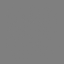

-


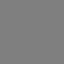

-


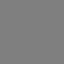

-


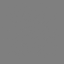

-


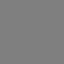

-


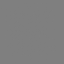

-


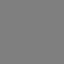

-


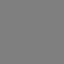

-


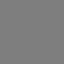

-


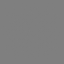

-


In [15]:
from PIL import Image

for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)
    
    im = Image.fromarray(Ys[i])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)
    print("-")